In [1]:
import snowflake.connector
import pandas as pd
import seaborn as sns
from snowflake.connector import DictCursor
import json
import warnings
import numpy as np
import matplotlib.pyplot as plt
from causalimpact import CausalImpact

import snowflake.connector
from snowflake.connector import DictCursor
import json
import matplotlib.pyplot as plt

with open("/Users/wilhelmleinemann/Downloads/data/snowflake_credentials.txt") as file:
    cred = json.load(file)
    
db_con = snowflake.connector.connect(**cred)
cur = db_con.cursor(DictCursor)

def sqlExec(query):
    df = pd.DataFrame(cur.execute(query).fetchall())
    df.columns = map(str.lower, df.columns)
    return df


def run_sql_query(query):
    return pd.DataFrame(cur.execute(query).fetchall())

In [2]:
start_date = '2021-10-01'

In [3]:
query_rates = """
with rates as (
select 
date_trunc('DAY', dateadd(minute,-15,dateadd(hour,-22,jr.created_at)))  as created_at,
jr.recommendation_id,
jrr.POSITION,
jrr.category_invoice_count,
LEAST(jr.NUMBER_OF_RESULTS,21) as MAX_POSITION,
to_double(LEAST(jr.NUMBER_OF_RESULTS,30)) as FACES,
to_double(jrr.poster_hourly_rate_cents / 100.0) as client_rate,
to_double(jrr.rabbit_hourly_rate_cents / 100.0) as rabbit_rate,
metros.name  as metro_name,
metros.id as metro_id,
100 * (1+ ((to_double(jrr.rabbit_hourly_rate_cents / 100.0) - ep.expected_px)/ep.expected_px)) as normalized_price

from job_recommendation_recommendations jrr 
LEFT JOIN job_recommendations jr ON jr.recommendation_id = jrr.recommendation_id
LEFT JOIN categories  ON jr.category_id  = categories.id
LEFT JOIN geographies  AS metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id
left join playground.bb_expected_price ep on ep.METRO_NAME = metros.name and ep.CAT_NAME = (case when lower(categories.name) like '%ikea%' then 'IKEA' else categories.name end)
    and (case when jr.vehicle_requirement = 'truck' then 'truck'
         when jr.vehicle_requirement = 'car_or_truck' then 'car_or_truck'
         else 'none' end ) = (case when ep.vehicle_requirement is NULL then 'none' else ep.vehicle_requirement end)
    and (case when jrr.category_invoice_count > 75 then 75 else jrr.category_invoice_count end) = ep.category_invoice_count

WHERE jr.created_at  >= '{start_date}' and
(jrr.position  < 21) AND ((UPPER(jr.locale ) = UPPER('en-US'))) 
  AND jr.last_in_funnel
and jr.category_id not in (1104,1106,1107)
)


select
date_trunc('day', rates.created_at) as day,
rates.recommendation_id,
rates.metro_name,
rates.metro_id,
sum(rates.rabbit_rate * w.WEIGHT) as wt_px_shown,
sum(rates.client_rate * w.WEIGHT) as client_px_wt,
sum(rates.normalized_price * w.WEIGHT) as norm_px_wt,
sum(rates.category_invoice_count * w.WEIGHT) as wt_cat_experience,
avg(rates.rabbit_rate) as rabbit_rate_avg,
avg(rates.client_rate) as client_rate_avg,
avg(FACES) as FACES

from
rates 
left join playground.bb_pos_weights w on w.MAX_POSITION = rates.MAX_POSITION and w.POSITION = rates.POSITION
 group by 1,2,3,4""".format(start_date = start_date)

In [4]:
query2 = """with a as (
select 
DISTINCT
metros.name as METRO_NAME
,date_trunc('DAY', dateadd(minute,-15,dateadd(hour,-22,jr.created_at))) as DAY
,jr.GUID as reco_guid
,case when jobs.id is NULL then NULL else jr.GUID end as jobs_guid
,case when ji.id is NULL then NULL else jr.GUID end as invoice_guid
,jr.recommendation_id 
,case when jobs.id is NULL then 0 else 1 end as job_booked
,case when ji.id is NULL then 0 else 1 end as invoiced
,ji.REVENUE_CENTS
,case when jr.is_first_booking then jr.GUID else NULL end as new_visitor
,case when jr.is_first_booking and jobs.id is not null then jr.GUID else NULL end as new_visitor_job

from job_recommendations jr
left join jobs on jobs.recommendation_id = jr.recommendation_id
LEFT JOIN job_invoices ji ON jobs.id = ji.job_id
LEFT JOIN geographies metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id 

where 
jr.created_at >= '{start_date}'
-- and last_in_funnel 
and  (jobs.suppress_level < 1000 OR jobs.suppress_level is NULL)
and ((UPPER(jr.locale ) = UPPER('en-US')))
and metros.LEVEL = 'metro'
and metros.ACTIVE = 1
and metros.COUNTRY_ID = 3791
and jr.category_id not in (1104,1106,1107)
)

select
METRO_NAME
,DAY
,COUNT(DISTINCT reco_guid) as RECO_VISITORS_UNIQUE
,COUNT(DISTINCT jobs_guid) as JOBS_VISITORS_UNIQUE
,COUNT(DISTINCT invoice_guid) as INVOICE_VISITORS_UNIQUE
,COUNT(DISTINCT RECOMMENDATION_ID) as RECOS
,SUM(JOB_BOOKED) as JOBS
,SUM(invoiced) as INVOICES
,SUM(REVENUE_CENTS) as REVENUE
,COUNT(distinct new_visitor) as NEW_RECO_VISITORS
,COUNT(distinct new_visitor_job) as NEW_JOB_VISITORS
,COUNT(DISTINCT reco_guid) - COUNT(distinct new_visitor) as RETURN_RECO_VISITORS
,COUNT(DISTINCT jobs_guid) - COUNT(distinct new_visitor_job) as RETURN_JOB_VISITORS

from a 
group by 1,2
order by 2,4 desc""".format(start_date = start_date)

In [5]:
query_invites = """
select
DISTINCT
metros.name as METRO_NAME
,date_trunc('DAY', dateadd(minute,-40,dateadd(hour,-18,jr.created_at))) as DAY
,jr.recommendation_id 
,case when jobs.id is NULL then 0 else 1 end as job_booked
,case when ji.id is NULL then 0 else 1 end as invoiced
,invitations.poster_hourly_rate_cents as poster_hourly_rate_cents
,invitations.rabbit_hourly_rate_cents as rabbit_hourly_rate_cents
,ji.REVENUE_CENTS
,pt.normalized_service_fee_in_cents + normalized_owner_trust_fee_in_cents + normalized_worker_fee_in_cents as ORDER_VALUE
,invitations.rabbit_category_experience


from invitations 
LEFT JOIN job_recommendations jr ON jr.recommendation_id = invitations.recommendation_id 
left join jobs on jobs.recommendation_id = jr.recommendation_id
LEFT JOIN job_invoices ji ON jobs.id = ji.job_id
LEFT JOIN geographies metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id 
LEFT JOIN payment_transactions pt ON pt.ID = ji.PAYMENT_TRANSACTION_ID

where last_in_funnel 
and jr.created_at >= '{start_date}'
and  (jobs.suppress_level < 1000 OR jobs.suppress_level is NULL)
and ((UPPER(jr.locale ) = UPPER('en-US')))
and jr.category_id not in (1104,1106,1107)
""".format(start_date = start_date)

In [6]:
def add_cohorts(df_rpv,g1,g2):
    df_rpv['COHORT'] = None
    df_rpv['COHORT'] = np.where(df_rpv.METRO_NAME.isin(g1), 'CONTROL',df_rpv.COHORT)
    df_rpv['COHORT'] = np.where(df_rpv.METRO_NAME.isin(g2), 'TREATMENT',df_rpv.COHORT)
    df_rpv = df_rpv[~df_rpv.COHORT.isna()]
    return df_rpv

In [7]:
df_recos_og = run_sql_query(query2)
df_rates_og = run_sql_query(query_rates)
df_invites_og = run_sql_query(query_invites)

In [8]:
########################
###EXPERIMENT COHORTS###
########################
g2 = ['LA & OC', 'Washington DC', 'Seattle', 'Denver', 'Miami', 'Houston', 'Minneapolis/St. Paul', 'Sacramento',\
      'Columbus', 'Las Vegas', 'Tampa/St. Petersburg', 'Orlando', 'Charlotte', 'Tulsa', 'Baton Rouge',\
      'Reno/Carson City', 'Albuquerque', 'Norfolk', 'Milwaukee', 'Tucson', 'Memphis']
g1 = ['New York City', 'Chicago', 'Boston', 'San Diego', 'Dallas/Fort Worth', 'Philadelphia', 'Ann Arbor/Detroit',\
      'St. Louis', 'San Antonio', 'Nashville', 'Baltimore', 'Kansas City', 'Jacksonville', 'Albany', 'Corpus Christi',\
      'Boise', 'El Paso', 'Richmond', 'Cleveland', 'Oklahoma City', 'Omaha']
#g1 = [x for x in df_rpv.METRO_NAME.unique() if x not in g2]

#g2 = ['LA & OC']
#g1 = ['New York City']


In [9]:
df_recos = add_cohorts(df_recos_og,g1,g2)
df_rates = add_cohorts(df_rates_og, g1, g2)
df_invites = add_cohorts(df_invites_og, g1, g2)

In [10]:
def make_ts_df(df_recos, df_rates, df_invites):
    df_gb = pd.DataFrame(df_recos.groupby(['COHORT','DAY'])['REVENUE'].sum()/df_recos.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb.columns = ['COHORT','DAY','REVENUE_PER_VISITOR']
    df_gb['REVENUE_PER_VISITOR'] = round(df_gb['REVENUE_PER_VISITOR'].astype(float) / 100,2)
    df_gb2 = pd.DataFrame(df_recos.groupby(['COHORT','DAY'])['JOBS_VISITORS_UNIQUE'].sum()/df_recos.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb2.columns = ['COHORT','DAY','JOBS_RATE']
    df_gb21 = pd.DataFrame(df_recos.groupby(['COHORT','DAY'])['JOBS_VISITORS_UNIQUE'].sum()/df_recos.groupby(['COHORT','DAY'])['RECOS'].sum()).reset_index()
    df_gb21.columns = ['COHORT','DAY','JOBS_RATE2']
    df_gb3 = pd.DataFrame(df_recos.groupby(['COHORT','DAY'])['INVOICE_VISITORS_UNIQUE'].sum()/df_recos.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb3.columns = ['COHORT','DAY','INVOICE_RATE']
    df_gb_cr = pd.DataFrame(df_recos.groupby(['COHORT','DAY'])['INVOICE_VISITORS_UNIQUE'].sum()/df_recos.groupby(['COHORT','DAY'])['JOBS_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb_cr.columns = ['COHORT','DAY','CLOSE_RATE']
    df_gb4 = df_rates.groupby(['COHORT','DAY'], as_index = False)['CLIENT_RATE_AVG','RABBIT_RATE_AVG','CLIENT_PX_WT','WT_PX_SHOWN','NORM_PX_WT','FACES','WT_CAT_EXPERIENCE'].mean()
    df_gb4 = df_gb4.rename(columns = {'CLIENT_RATE_AVG':'CLIENT_PX_SHOWN_AVG','RABBIT_RATE_AVG':'RABBIT_PX_SHOWN_AVG','NORM_PX_WT':'PX_SHOWN_IDX'})
    df_gb4 = df_gb4.rename(columns = {'CLIENT_PX_WT':'CLIENT_PX_SHOWN_WT','FACES':'AVG_FACES'})
    df_gb5 = df_invites.groupby(['COHORT','DAY'], as_index = False)[['ORDER_VALUE','POSTER_HOURLY_RATE_CENTS','RABBIT_HOURLY_RATE_CENTS','RABBIT_CATEGORY_EXPERIENCE']].mean()
    df_gb5 = df_gb5.rename(columns = {'ORDER_VALUE':'AOV','POSTER_HOURLY_RATE_CENTS':'AVG_INVITE_CLIENT_PX','RABBIT_HOURLY_RATE_CENTS':'AVG_INVITE_RABBIT_PX','RABBIT_CATEGORY_EXPERIENCE':'AVG_INVITE_CAT_EXP'})
    df_tracking = df_gb.merge(df_gb2).merge(df_gb3).merge(df_recos.groupby(['COHORT','DAY'], as_index = False)['RECOS','JOBS','INVOICES'].sum())
    df_tracking = df_tracking.merge(df_gb4).merge(df_gb5)
    df_tracking = df_tracking.merge(df_gb_cr, how = 'left')
    df_tracking = df_tracking.merge(pd.DataFrame(df_recos.groupby(['COHORT','DAY'],as_index = False)['REVENUE'].sum()))
    df_gb_rr = pd.DataFrame(df_recos.groupby(['COHORT','DAY'])['REVENUE'].sum()/df_recos.groupby(['COHORT','DAY'])['RECOS'].sum()).reset_index()
    df_gb_rr.columns = ['COHORT','DAY','REVENUE_PER_RECO']
    df_tracking = df_tracking.merge(df_gb_rr, how = 'left')
    df_gbb = pd.DataFrame(df_recos.groupby(['COHORT','DAY'])['RECOS'].sum()/df_recos.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gbb.columns = ['COHORT','DAY','RECO_PER_VISITOR']
    df_tracking = df_tracking.merge(df_gbb, how = 'left')
    df_tracking = df_tracking.merge(df_gb21, how = 'left')
    df_tracking['INVOICE_RATIO'] = df_tracking['INVOICES'] / df_tracking['RECOS']
    return df_tracking

In [11]:
df_exp = make_ts_df(df_recos,df_rates,df_invites)

<ipython-input-10-b7c73da027d3>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_gb4 = df_rates.groupby(['COHORT','DAY'], as_index = False)['CLIENT_RATE_AVG','RABBIT_RATE_AVG','CLIENT_PX_WT','WT_PX_SHOWN','NORM_PX_WT','FACES','WT_CAT_EXPERIENCE'].mean()
<ipython-input-10-b7c73da027d3>:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tracking = df_gb.merge(df_gb2).merge(df_gb3).merge(df_recos.groupby(['COHORT','DAY'], as_index = False)['RECOS','JOBS','INVOICES'].sum())


In [12]:
df_exp.columns

Index(['COHORT', 'DAY', 'REVENUE_PER_VISITOR', 'JOBS_RATE', 'INVOICE_RATE',
       'RECOS', 'JOBS', 'INVOICES', 'CLIENT_PX_SHOWN_AVG',
       'RABBIT_PX_SHOWN_AVG', 'CLIENT_PX_SHOWN_WT', 'WT_PX_SHOWN',
       'PX_SHOWN_IDX', 'AVG_FACES', 'WT_CAT_EXPERIENCE', 'AOV',
       'AVG_INVITE_CLIENT_PX', 'AVG_INVITE_RABBIT_PX', 'AVG_INVITE_CAT_EXP',
       'CLOSE_RATE', 'REVENUE', 'REVENUE_PER_RECO', 'RECO_PER_VISITOR',
       'JOBS_RATE2', 'INVOICE_RATIO'],
      dtype='object')

In [13]:
df_recos.columns

Index(['METRO_NAME', 'DAY', 'RECO_VISITORS_UNIQUE', 'JOBS_VISITORS_UNIQUE',
       'INVOICE_VISITORS_UNIQUE', 'RECOS', 'JOBS', 'INVOICES', 'REVENUE',
       'NEW_RECO_VISITORS', 'NEW_JOB_VISITORS', 'RETURN_RECO_VISITORS',
       'RETURN_JOB_VISITORS', 'COHORT'],
      dtype='object')

## Plot Series

In [14]:
def plot_cols(df_exp, col_name, experiment_date = '2022-02-07', max_date = None):
    if max_date:
        df_exp2 = df_exp[df_exp.DAY <= max_date]
    else:
        
        df_exp2 = df_exp.copy()
    print(f'corr = {np.corrcoef(df_exp2[df_exp2.COHORT == "CONTROL"][col],df_exp2[df_exp2.COHORT == "TREATMENT"][col])[0][1]}')
    fig,ax = plt.subplots(figsize = (15,5))
    ax = sns.lineplot(data=df_exp2, x="DAY", y=col, hue="COHORT")
    if experiment_date:
        plt.axvline(x = pd.to_datetime(experiment_date), color='black')

corr = 0.5627481737746326


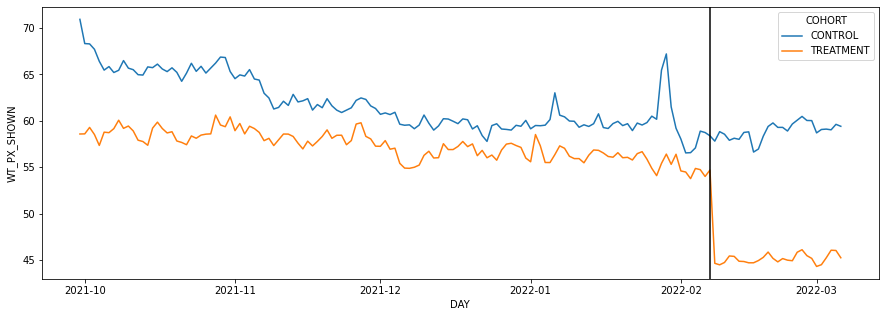

In [15]:
col = 'WT_PX_SHOWN'
plot_cols(df_exp, col)

corr = 0.8383198163627353


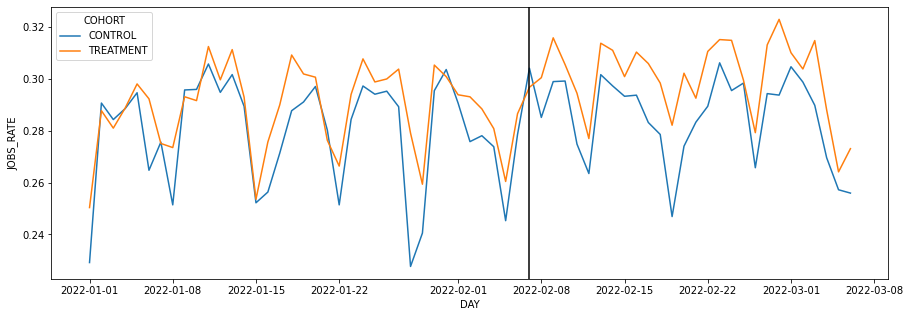

In [16]:
#col = 'AVG_INVITE_RABBIT_PX'
col = 'JOBS_RATE'
plot_cols(df_exp[df_exp.DAY >= '2022-01-01'], col)

corr = 0.9547006670346699
corr = 0.7902894072659521


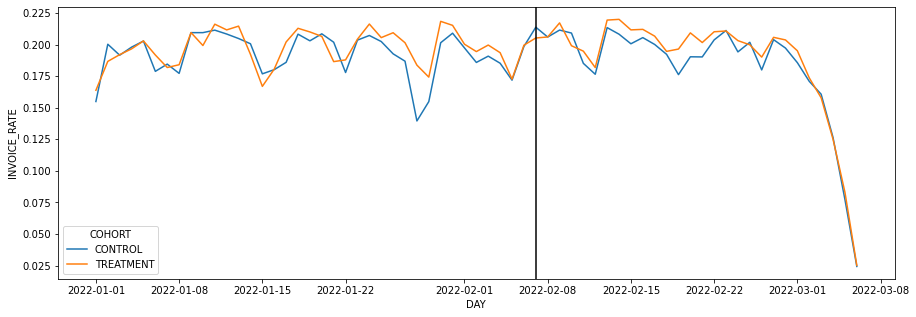

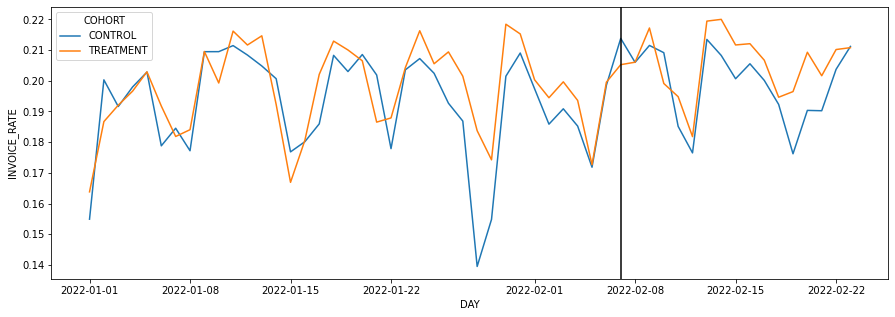

In [17]:
col = 'INVOICE_RATE'
#col = 'INVOICES'
#col = 'RECOS'
#col = 'RECO_PER_VISITOR'
#col = 'REVENUE_PER_RECO'
plot_cols(df_exp[df_exp.DAY >= '2022-01-01'], col)
plot_cols(df_exp[(df_exp.DAY >= '2022-01-01') & (df_exp.DAY <= '2022-02-23') ], col)

### df_exp.columns

## Run Causal Impact

In [61]:
#col = 'PX_SHOWN_IDX'
#col = 'WT_PX_SHOWN'
#col = 'INVOICES'
#col = 'RECOS'
#col = 'AVG_FACES'
#col = 'AVG_INVITE_RABBIT_PX'
#col = 'INVOICE_RATE'
col = 'JOBS_RATE'
#col = 'RECO_PER_VISITOR'
#col = 'REVENUE_PER_VISITOR'
#col = 'CLOSE_RATE'

#A/B
data = df_exp[df_exp.COHORT == 'TREATMENT'][['DAY',col]].rename(columns = {col:'y'}).set_index('DAY')
#data = data.join(df_exp[df_exp.COHORT == 'CONTROL'][['DAY',col]].rename(columns = {col:'X'}).set_index('DAY'))

data = data.join(df_exp[df_exp.COHORT == 'CONTROL'][['DAY','RECOS']].rename(columns = {'RECOS':'X'}).set_index('DAY'))
data = data.join(df_exp[df_exp.COHORT == 'CONTROL'][['DAY',col]].rename(columns = {col:'X2'}).set_index('DAY'))
data = data.join(df_exp[df_exp.COHORT == 'CONTROL'][['DAY','AVG_FACES']].rename(columns = {'AVG_FACES':'X3'}).set_index('DAY'))


#A/A
#data = df_exp[df_exp.COHORT == 'CONTROL'][['DAY',col]].rename(columns = {col:'y'}).set_index('DAY')
#data = data.join(df_exp[df_exp.COHORT == 'CONTROL'][['DAY',col]].rename(columns = {col:'X'}).set_index('DAY'))

In [62]:
pre_period = ['2021-12-01','2022-02-07']
#post_period = ['2022-02-01',df_exp.DAY.max()]
post_period = ['2022-02-08','2022-03-05']
if col in ('REVENUE_PER_VISITOR','INVOICE_RATE','CLOSE_RATE'):
    post_period = ['2022-02-08','2022-02-27']
ci = CausalImpact(data[['y','X','X2','X3']], pre_period, post_period, prior_level_sd=None, nseasons = [{'period':7}])
#ci = CausalImpact(data[['y','X']], pre_period, post_period, prior_level_sd=None, nseasons = [{'period':7}])
#ci = CausalImpact(data[['y','X']], pre_period, post_period, prior_level_sd=None, standardize = True)

/Users/wilhelmleinemann/opt/anaconda3/envs/py385_ci/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/wilhelmleinemann/opt/anaconda3/envs/py385_ci/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


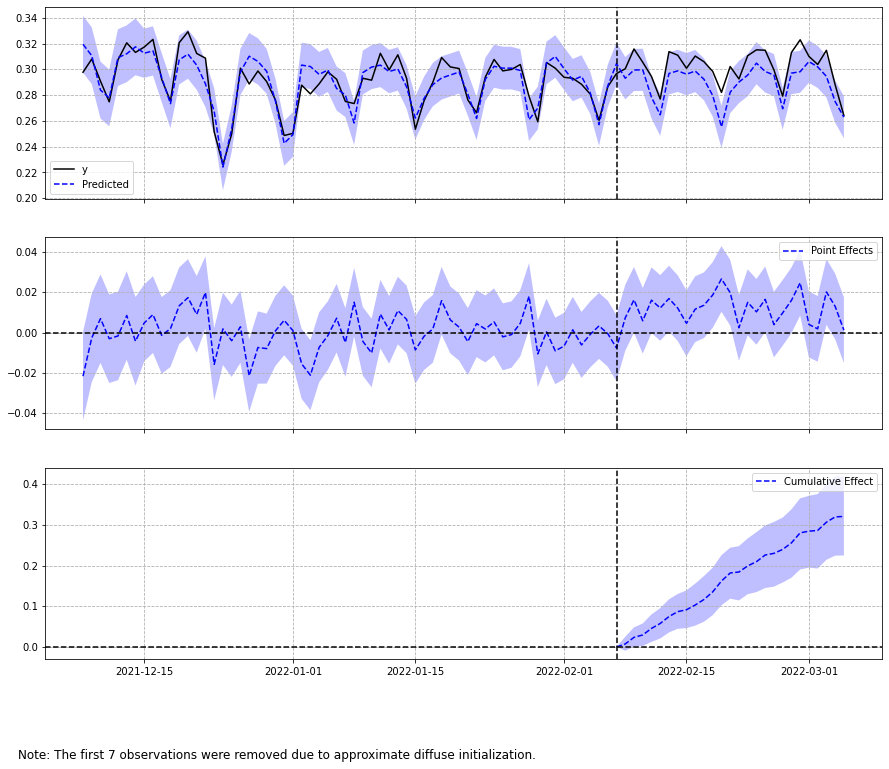

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.3                7.85
Prediction (s.d.)         0.29 (0.0)         7.53 (0.05)
95% CI                    [0.29, 0.29]       [7.43, 7.62]

Absolute effect (s.d.)    0.01 (0.0)         0.32 (0.05)
95% CI                    [0.01, 0.02]       [0.23, 0.42]

Relative effect (s.d.)    4.27% (0.66%)      4.27% (0.66%)
95% CI                    [2.99%, 5.57%]     [2.99%, 5.57%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [63]:
ci.plot()
print(ci.summary())

In [45]:
ci.trained_model.params

sigma2.irregular             2.528641e-01
sigma2.level                 7.163728e-03
sigma2.freq_seasonal_7(3)    1.909816e-11
beta.X                       2.699922e-01
beta.X2                      2.341389e-01
beta.X3                      2.474294e-01
dtype: float64

In [116]:
df_exp[df_exp['DAY'] > '2022-01-31']

,COHORT,DAY,REVENUE_PER_VISITOR,JOBS_RATE,INVOICE_RATE,RECOS,JOBS,INVOICES,CLIENT_PX_SHOWN_AVG,RABBIT_PX_SHOWN_AVG,...,AOV,AVG_INVITE_CLIENT_PX,AVG_INVITE_RABBIT_PX,AVG_INVITE_CAT_EXP,CLOSE_RATE,REVENUE,REVENUE_PER_RECO,RECO_PER_VISITOR,JOBS_RATE2,INVOICE_RATIO
124,CONTROL,2022-02-01,6.81,0.290822,0.188005,20742,2102,1182,59.382594,57.339544,...,13318.453020,4898.786194,4779.961649,285.097795,0.646459,4135877.0,199.396249,3.417696,0.085093,0.056986
125,CONTROL,2022-02-02,6.22,0.275954,0.172639,20421,1993,1074,57.602243,55.923255,...,12751.607807,4792.706209,4671.983847,285.193337,0.625607,3712010.0,181.774154,3.419457,0.080701,0.052593
126,CONTROL,2022-02-03,6.19,0.278579,0.174562,20901,1939,1060,56.829250,55.846328,...,13335.612093,4942.786810,4875.306748,315.592025,0.626617,3606526.0,172.552797,3.587539,0.077652,0.050715
127,CONTROL,2022-02-04,5.47,0.274020,0.162952,17824,1720,877,56.773620,56.179594,...,12405.009989,4847.911514,4809.245604,285.495746,0.594670,2844605.0,159.594087,3.425058,0.080004,0.049203
128,CONTROL,2022-02-05,4.53,0.245298,0.135221,16430,1487,704,57.995258,57.685329,...,13026.963855,5047.219780,5021.202327,305.416290,0.551251,2288312.0,139.276446,3.252821,0.075411,0.042848
129,CONTROL,2022-02-06,4.53,0.278733,0.137487,19154,1834,792,57.789936,57.566690,...,12505.631313,4925.557800,4916.329966,348.268799,0.493256,2532246.0,132.204553,3.428929,0.081289,0.041349
130,CONTROL,2022-02-07,3.80,0.304291,0.117856,18944,1900,649,57.382615,57.258386,...,11977.909228,4870.628938,4861.558996,315.608115,0.387315,2029567.0,107.135082,3.549560,0.085726,0.034259
131,CONTROL,2022-02-08,2.17,0.284743,0.065899,18765,1792,362,56.921519,56.792024,...,12546.691415,4902.751394,4898.996656,279.130992,0.231432,1150542.0,61.313189,3.543240,0.080362,0.019291
132,CONTROL,2022-02-09,0.12,0.246463,0.006287,10611,941,20,57.420712,57.326044,...,11480.603175,4954.281114,4950.913838,299.889469,0.025510,39424.0,3.715390,3.335743,0.073886,0.001885
257,TREATMENT,2022-02-01,7.02,0.293858,0.191489,16753,1751,1011,53.342336,53.069111,...,12740.717949,4555.955568,4534.083240,153.286277,0.651639,3496135.0,208.687101,3.362706,0.087387,0.060347


In [137]:
df_pre = df_exp[(df_exp['DAY']>'2022-01-31') & (df_exp['DAY']<'2022-02-08')]
df_post = df_exp[df_exp['DAY']>'2022-02-07']

In [138]:
df_pre.groupby('COHORT').sum()[['RECOS','JOBS','INVOICES','REVENUE']]

,RECOS,JOBS,INVOICES,REVENUE
COHORT,,,,
CONTROL,134416,12975,6338,21149143.0
TREATMENT,117195,11984,5799,20741269.0


In [134]:
df_post.groupby('COHORT').sum()[['RECOS','JOBS','INVOICES','REVENUE']]

,RECOS,JOBS,INVOICES,REVENUE
COHORT,,,,
CONTROL,29376,2733,382,1189966.0
TREATMENT,28880,2846,346,1134147.0


In [121]:
df_pre.mean()

<ipython-input-121-0b98a0662c22>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_pre.mean()


REVENUE_PER_VISITOR     4.685556e+00
JOBS_RATE               2.806493e-01
INVOICE_RATE            1.304257e-01
RECOS                   1.721483e+04
JOBS                    1.696556e+03
INVOICES                7.147222e+02
CLIENT_PX_SHOWN_AVG     5.455961e+01
RABBIT_PX_SHOWN_AVG     5.411945e+01
CLIENT_PX_SHOWN_WT      5.548433e+01
WT_PX_SHOWN             5.506336e+01
PX_SHOWN_IDX            1.398687e+02
AVG_FACES               2.183539e+01
WT_CAT_EXPERIENCE       2.195423e+02
AOV                     1.279032e+04
AVG_INVITE_CLIENT_PX    4.690184e+03
AVG_INVITE_RABBIT_PX    4.661718e+03
AVG_INVITE_CAT_EXP      2.231506e+02
CLOSE_RATE              4.624645e-01
REVENUE                 2.456362e+06
REVENUE_PER_RECO        1.366763e+02
RECO_PER_VISITOR        3.429921e+00
JOBS_RATE2              8.180261e-02
INVOICE_RATIO           3.973453e-02
dtype: float64

In [122]:
df_post.mean()

<ipython-input-122-8de7fe54dea7>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_post.mean()


REVENUE_PER_VISITOR          1.145000
JOBS_RATE                    0.275994
INVOICE_RATE                 0.035210
RECOS                    14564.000000
JOBS                      1394.750000
INVOICES                   182.000000
CLIENT_PX_SHOWN_AVG         51.595510
RABBIT_PX_SHOWN_AVG         51.526512
CLIENT_PX_SHOWN_WT          51.478234
WT_PX_SHOWN                 51.414584
PX_SHOWN_IDX               130.790088
AVG_FACES                   22.474540
WT_CAT_EXPERIENCE          217.288699
AOV                      11941.239591
AVG_INVITE_CLIENT_PX      4590.741079
AVG_INVITE_RABBIT_PX      4587.783333
AVG_INVITE_CAT_EXP         213.499968
CLOSE_RATE                   0.121950
REVENUE                 581028.250000
REVENUE_PER_RECO            32.308253
RECO_PER_VISITOR             3.451645
JOBS_RATE2                   0.079881
INVOICE_RATIO                0.010209
dtype: float64